In [1]:
# Projeto de Aprendizado de Máquina
# Aprendizado de máquina no auxílio para diagnósticos médicos: Diferencial entre COVID-19 e Pneumonia por Raio-X de Tórax

# Caio Bohlhalter de Souza
# Jeferson Patrick Dietrich Filho

# Projeto orientado pela Profª Verônica Oliveira de Carvalho

# Proposta de projeto:
# https://docs.google.com/document/d/1uEbctbl0NRMt0JqrIm3f5ihobDgLaR9f0iVCDjmQZsY/edit?usp=sharing

In [2]:
# Orientações para importar as bibliotecas
# O código do projeto foi feito com o Jupyter da Anaconda.
# Para instalar alguns módulos/bibliotecas será necessário rodar os seguintes códigos no Anaconda Prompt

# cv2
# conda install conda-forge::opencv
# pip install opencv-contrib-python

# Para outras bibliotecas que não tiver o módulo/biblioteca instalado, deve-se fazer o mesmo

#--------------------------------------------------------------------------------------------#

# Bibliotecas de sistema
import os
import time
import shutil
import pathlib
import itertools

# Bibliotecas para manipulação dos dados
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Bibliotecas para Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.optimizers import Adam
import random
from tqdm.notebook import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

# Biblioteca para filtrar os 'warnings'
import warnings
warnings.filterwarnings("ignore")

print ('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


In [3]:
# Esse bloco do código tem como objetivo carregar as imagens a partir de um diretório, podendo ser local ou remoto.
# Nesse caso, optamos por carregar a partir de um diretório local, dentro da pasta com o arquivo do código, no Jupyter Notebook.

# Além do carregamento das imagens, elas também estarão sendo pré-processadas, seguindos essas etapas:
    # 1. Convertendo para tons de cinza (GrayScale)
        # Converter as imagens para tons de cinza simplifica a análise das imagens, melhorando o aprendizado do algoritmo/modelo
    # 2. Redimensionando para 128x128px
        # Isso torna a imagem mais leve e, portanto, mais fácil de ser processada

# Função para carregar imagens e máscaras
    # classes: categorias das imagens
    # imagens: imagens de raio-x
    # mascaras: limtar a área de análise (pulmão)
    # labels: rótulos (resultado do exame)

def load_data(diretorio):
    classes = os.listdir(diretorio)
    imagens = []
    mascaras = []
    labels = []

    # Populando os diretórios de imagens e máscaras
    for classe in classes:
        diretorio_classe = os.path.join(diretorio, classe)
        if os.path.isdir(diretorio_classe):
            subdiretorio_imagem = os.path.join(diretorio_classe, 'images')
            subdiretorio_mascara = os.path.join(diretorio_classe, 'masks')

            # Verificando se a imagem é valida (.png) e carregando as imagens dentro do diretório
            for arquivo in os.listdir(subdiretorio_imagem):
                if arquivo.endswith(".png"):
                    image_path = os.path.join(subdiretorio_imagem, arquivo)
                    if not os.path.exists(image_path):
                        print(f"Imagem não encontrada: {image_path}")
                        continue

                    # Pré-processamento da imagem, conforme descrito anteriormente
                    imagem = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Deixando a imagem em tons de cinza
                    imagem = cv2.resize(imagem, (128,128)) # Redimensionando a imagem
                    imagens.append(imagem) # Adiciona a imagem pré-processada

                    # Realizando o mesmo processo para as máscaras
                    filename_mascara = arquivo
                    mask_path = os.path.join(subdiretorio_mascara, filename_mascara)
                    if not os.path.exists(mask_path):
                        print(f"Máscara não encontrada: {mask_path}")
                        continue

                    mascara = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mascara = cv2.resize(mascara, (128,128))
                    mascaras.append(mascara)

                    # Rotulando baseado na classe
                    labels.append(classe)

    return np.array(imagens), np.array(mascaras), np.array(labels)

diretorio = "./COVID-19_Radiography_Dataset/"
imagens, mascaras, labels = load_data(diretorio)

In [4]:
# Verificando o tamanho de cada array, eles devem ter a mesma quantidade de elementos, pois a análise será feita no conjunto imagem, máscara, label

print(len(imagens))
print(len(mascaras))
print(len(labels))

21165
21165
21165


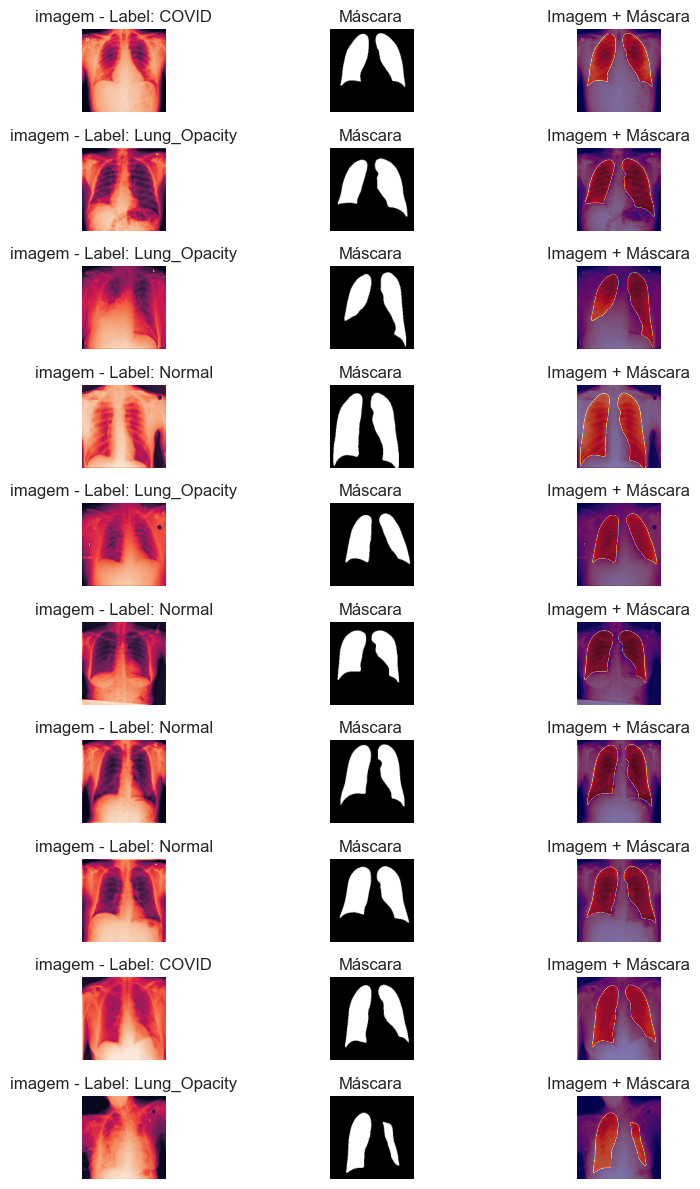

In [5]:
# Esse bloco tem como objetivo mostrar o que foi carregado até o momento
# Será plotado uma amostra aleatória dos raios x já com o laudo (label), a máscara criada, e a imagem e máscara sobrepostas

# Como o objetivo é mostrar apenas as imagens, será utilizado plt.axis('off') para tal.
 
def plot_imagem_mascara(imagens, mascaras, labels, num_imagens=10):
    indices = np.random.choice(len(imagens), num_imagens, replace=False)

    # width: 15
    # height: 12 (para 10 imagens)
    plt.figure(figsize=(15, 6 * num_imagens // 5))

    for i, idx in enumerate(indices, start=1):
        
        # Coluna das imagens
        plt.subplot(num_imagens, 6, 6 * i - 2)
        plt.imshow(imagens[idx])
        plt.axis('off')
        plt.title(f"imagem - Label: {labels[idx]}")

        # Coluna das máscaras
        plt.subplot(num_imagens, 6, 6 * i - 1)
        plt.imshow(mascaras[idx], cmap='gray')
        plt.axis('off')
        plt.title("Máscara")

        # Coluna das máscaras sobrepostas nas imagens
        plt.subplot(num_imagens, 6, 6 * i)
        plt.imshow(imagens[idx])
        plt.imshow(mascaras[idx], cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title("Imagem + Máscara")

    plt.tight_layout()
    plt.show()

plot_imagem_mascara(imagens, mascaras, labels, num_imagens=10)

In [6]:
# Agora daremos início ao treinamento do algoritmo baseado no modelo U2Net
# Inicialmente, será dividido, seguindo a proporção de 80% para treino e 20% para teste, o array principal. 

imagens_treino, imagens_teste, mascaras_treino, mascaras_teste = train_test_split(imagens, mascaras, test_size=0.2, random_state=42)
imagens_treino = np.array(imagens_treino).reshape(len(imagens_treino),128,128)
imagens_teste = np.array(imagens_teste).reshape(len(imagens_teste),128,128)
print(imagens_treino.shape)
print(imagens_teste.shape)
print(mascaras_treino.shape)
print(mascaras_teste.shape)

(16932, 128, 128)
(4233, 128, 128)
(16932, 128, 128)
(4233, 128, 128)


In [7]:
# Esse bloco tem como objetivo executar todos os passos do modelo U2-Net
# O modelo U2-Net é uma rede neural de convolução para segmentação de imagens (salient object detection),
# segmentando o objeto principal da imagem, em nosso caso o pulmão, e gerando uma máscara dele.

# Bloco de Convolução
    # 1. Convolução 2D: 
    # 2. Normalização da saída: Estabilizar e acelerar o treinamento
    # 3. ReLU (Rectified Linear Unit): Representações complexas com uma rede não-linear
        # Não configurando dessa maneira, a rede seria uma combinação linear das entradas, limitando as representações
def convolucao(shape, canal_output, rate=1):
    x = tf.keras.layers.Conv2D(canal_output, 3, padding="same", dilation_rate=1)(shape)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

# Recurrent Residual U-Net Layer: Combinação de convoluções, pooling, upsampling e conexões residuais; Formato U;
    # Pooling: Reduz as dimensões do que foi extraído
    # Upsampling: Aumenta as dimensões do que foi extraído
    # Conexões residuais: Auxilia no treinamento de redes neurais profundas na propagação da informação e gradiente
def RSU_L(shape, canal_output, M_ch, num_layers, rate=2):
    # Convolução
    x = convolucao(shape, canal_output)
    canal_input = x

    # A variável 'mapeamento_caracteristica' armazena as features maps geradas; Reutilizada para aprimorar o upsampling;
    mapeamento_caracteristica = []
    x = convolucao(x, M_ch)
    mapeamento_caracteristica.append(x)

    # Camadas de Pooling + Convolução
    for i in range(num_layers-2):
        x = tf.keras.layers.MaxPool2D((2, 2))(x)
        x = convolucao(x, M_ch)
        mapeamento_caracteristica.append(x)
    
    # Convolução no nível mais profundo
    x = convolucao(x, M_ch, rate=rate)
    mapeamento_caracteristica.reverse()
    x = tf.keras.layers.Concatenate()([x, mapeamento_caracteristica[0]])
    x = convolucao(x, M_ch)

    # Camadas de Upsampling + Convolução
    for i in range(num_layers-3):
        x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = tf.keras.layers.Concatenate()([x, mapeamento_caracteristica[i+1]])
        x = convolucao(x, M_ch)

    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = tf.keras.layers.Concatenate()([x, mapeamento_caracteristica[-1]])
    x = convolucao(x, canal_output)

    # Conexão residual
    x = tf.keras.layers.Add()([x, canal_input])
    return x

# Residual U-Shape 4F: Semelhante ao anterior, RSU_U, mas agora com 4 camadas fixas
def RSU_4F(shape, canal_output, M_ch):
    x0 = convolucao(shape, canal_output, rate=1)

    x1 = convolucao(x0, M_ch, rate=1)
    x2 = convolucao(x1, M_ch, rate=2)
    x3 = convolucao(x2, M_ch, rate=4)

    x4 = convolucao(x3, M_ch, rate=8)

    x = tf.keras.layers.Concatenate()([x4, x3])
    x = convolucao(x, M_ch, rate=4)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = convolucao(x, M_ch, rate=2)

    x = tf.keras.layers.Concatenate()([x, x1])
    x = convolucao(x, canal_output, rate=1)

    x = tf.keras.layers.Add()([x, x0])
    return x

# Arquitetura U2-Net: Estrutura de encoders e decoders
    # 1. shape: dimensões do input
    # 2. canal_output: canais de saída
    # 3. M_ch: canais intermediários
    # 4. num_classes: número de classes para segmentação (padrão é 1)
def u2net(shape, canal_output, M_ch, num_classes=1):
    # Camada de entrada da rede
    inputs = tf.keras.layers.Input(shape)

    # Encoder: extrair as principais características das imagens do input
    e1 = RSU_L(inputs, canal_output[0], M_ch[0], 7)
    p1 = tf.keras.layers.MaxPool2D((2, 2))(e1)

    e2 = RSU_L(p1, canal_output[1], M_ch[1], 6)
    p2 = tf.keras.layers.MaxPool2D((2, 2))(e2)

    e3 = RSU_L(p2, canal_output[2], M_ch[2], 5)
    p3 = tf.keras.layers.MaxPool2D((2, 2))(e3)

    e4 = RSU_L(p3, canal_output[3], M_ch[3], 4)
    p4 = tf.keras.layers.MaxPool2D((2, 2))(e4)

    e5 = RSU_4F(p4, canal_output[4], M_ch[4])
    p5 = tf.keras.layers.MaxPool2D((2, 2))(e5)

    # Decoder: Retorna as características para a resolução original
    b1 = RSU_4F(p5, canal_output[5], M_ch[5])
    b2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    d1 = tf.keras.layers.Concatenate()([b2, e5])
    d1 = RSU_4F(d1, canal_output[6], M_ch[6])
    u1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = tf.keras.layers.Concatenate()([u1, e4])
    d2 = RSU_L(d2, canal_output[7], M_ch[7], 4)
    u2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = tf.keras.layers.Concatenate()([u2, e3])
    d3 = RSU_L(d3, canal_output[8], M_ch[8], 5)
    u3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = tf.keras.layers.Concatenate()([u3, e2])
    d4 = RSU_L(d4, canal_output[9], M_ch[9], 6)
    u4 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = tf.keras.layers.Concatenate()([u4, e1])
    d5 = RSU_L(d5, canal_output[10], M_ch[10], 7)

    # Como são produzidas diversas saídas, elas são concatenadas afim de unificá-las
    y1 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d5)

    y2 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d4)
    y2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d3)
    y3 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d2)
    y4 = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(d1)
    y5 = tf.keras.layers.UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(b1)
    y6 = tf.keras.layers.UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = tf.keras.layers.Conv2D(num_classes, 3, padding="same")(y0)

    # Segmentação binária; Saídas nos valores 0 e 1
    y0 = tf.keras.layers.Activation("sigmoid")(y0)
    y1 = tf.keras.layers.Activation("sigmoid")(y1)
    y2 = tf.keras.layers.Activation("sigmoid")(y2)
    y3 = tf.keras.layers.Activation("sigmoid")(y3)
    y4 = tf.keras.layers.Activation("sigmoid")(y4)
    y5 = tf.keras.layers.Activation("sigmoid")(y5)
    y6 = tf.keras.layers.Activation("sigmoid")(y6)

    # Definindo o modelo final
    modelo = tf.keras.models.Model(inputs, outputs=y0, name="U2-Net")
    return modelo

# Instância do modelo, mas com os parâmetros pré-definidos
def instancia_u2net(input_shape, num_classes=1):
    canal_output = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    M_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    modelo = u2net(input_shape, canal_output, M_ch, num_classes=num_classes)
    return modelo

# Idem à função anterior, mas em uma versão mais leve
def instancia_u2net_lite(input_shape, num_classes=1):
    canal_output = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    M_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    input_shape_with_channels = input_shape + (1,)
    modelo = u2net(input_shape_with_channels, canal_output, M_ch, num_classes=num_classes)
    return modelo

modelo_u2net = instancia_u2net_lite((128,128))

In [8]:
# Utilizamos o algoritmo Adam para otimizar o treinamento
    # Adapta as taxas de aprendizado baseado nas perdas passadas
otimizador = Adam(learning_rate=1e-3)
modelo_u2net.compile(optimizer=otimizador, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Definição dos callbacks a serem utilizados
    # reduz_aprendizado: Reduz o learning rate se uma taxa para de melhorar
    # checkpoint: Salva o a melhor epoch até o momento
    # stop_treino: Para o treinamento se a métrica monitorada deixa de melhorar

def callbacks():
    reduz_aprendizado = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('ChestSegmentor.keras',verbose=1, save_best_only= True)
    stop_treino = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduz_aprendizado, checkpoint, stop_treino]

In [10]:
# Finalmente, podemos treinar o nosso modelo (U2-Net) com as imagens e máscaras dos raios x que temos

history = modelo_u2net.fit(imagens_treino, mascaras_treino, validation_split = 0.2, batch_size = 16, epochs = 15, callbacks=callbacks())

Epoch 1/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2135 - loss: -940.7579
Epoch 1: val_loss improved from inf to -958.33441, saving model to ChestSegmentor.keras
847/847 ━━━━━━━━━━━━━━━━━━━━ 1484s 2s/step - accuracy: 0.2137 - loss: -940.7825 - val_accuracy: 0.4839 - val_loss: -958.3344 - learning_rate: 0.0010
Epoch 2/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5314 - loss: -970.9178
Epoch 2: val_loss improved from -958.33441 to -959.34174, saving model to ChestSegmentor.keras
847/847 ━━━━━━━━━━━━━━━━━━━━ 1433s 2s/step - accuracy: 0.5314 - loss: -970.9144 - val_accuracy: 0.5432 - val_loss: -959.3417 - learning_rate: 0.0010
Epoch 3/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6034 - loss: -969.1215
Epoch 3: val_loss did not improve from -959.34174
847/847 ━━━━━━━━━━━━━━━━━━━━ 1426s 2s/step - accuracy: 0.6034 - loss: -969.1212 - val_accuracy: 0.3306 - val_loss: -957.2769 - learning_rate: 0.0010
Epoch 4/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc

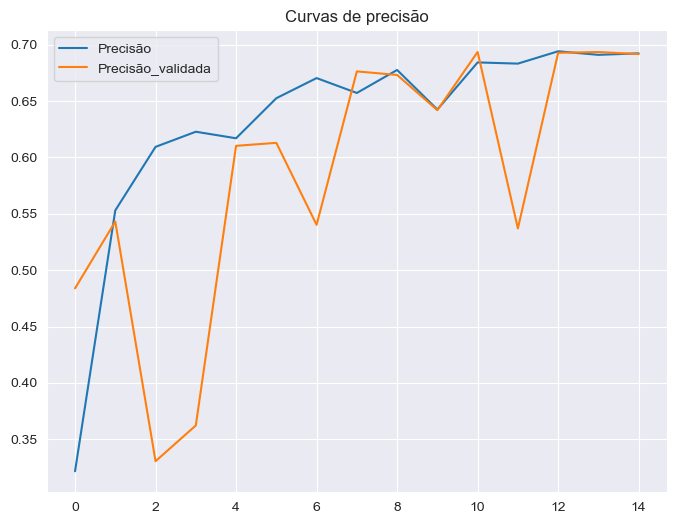

In [11]:
# Após o treinamento do algoritmo, a análise das métricas será feita com o auxílio de gráfico, para melhorar a visualização dos dados.
# Afim de evitar o overfitting, será comparado a precisão e a validação da precisão.
# Tendo em mente utilizar esse algoritmo para um outro dataset de imagens de Raio-X, a precisão que deve ser considerada é a validada.

plt.figure(figsize=(8,6))
plt.title("Curvas de precisão")
plt.plot(history.history["accuracy"], label="Precisão")
plt.plot(history.history["val_accuracy"], label="Precisão_validada")
plt.legend()
plt.show()

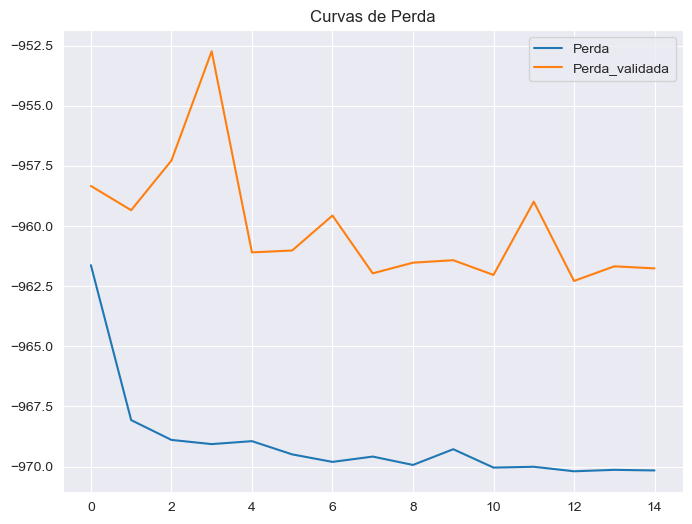

In [12]:
plt.figure(figsize=(8,6))
plt.title("Curvas de Perda")
plt.plot(history.history["loss"], label="Perda")
plt.plot(history.history["val_loss"], label="Perda_validada")
plt.legend()
plt.show()

133/133 ━━━━━━━━━━━━━━━━━━━━ 100s 733ms/step


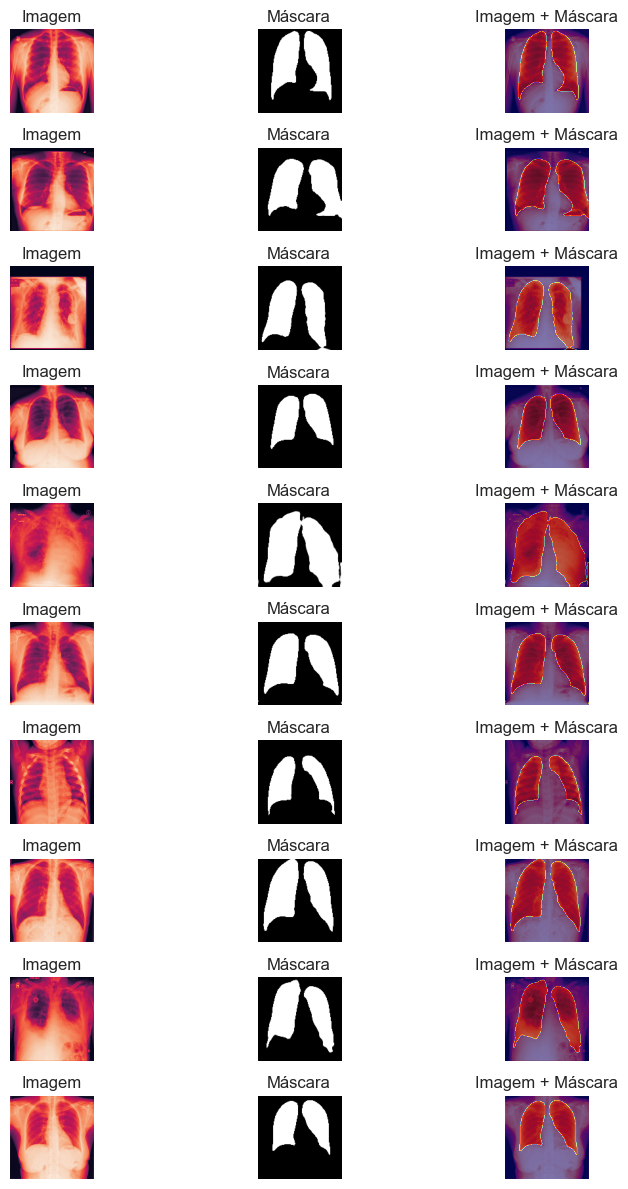

In [13]:
# Agora será feito a mesma visualização de uma amostra aleatória de raios x, máscara e sobreposição da máscara na imagem.
# No entanto, como o algotitmo já foi executado, iremos utilizar ele como base para gerar novas imagens.

modelo_u2net.load_weights("ChestSegmentor.keras")
def gerar_mascaras(modelo, imagens_teste):
    mascaras = modelo.predict(imagens_teste)
    return mascaras

# Essa é a função 'plot_imagem_mascara' para o conjunto teste
def plot_teste_imagem_mascara(imagens, mascaras, num_imagens=10):
    indices = np.random.choice(len(imagens), num_imagens, replace=False)

    plt.figure(figsize = (15, 6 * num_imagens // 5))

    for i, idx in enumerate(indices, start=1):
        
        # Coluna das imagens
        plt.subplot(num_imagens, 6, 6 * i - 2)
        plt.imshow(imagens[idx])
        plt.axis('off')
        plt.title("Imagem")

        # Coluna das máscaras
        plt.subplot(num_imagens, 6, 6 * i - 1)
        plt.imshow(mascaras[idx], cmap='gray')
        plt.axis('off')
        plt.title("Máscara")

        # Coluna das máscaras sobrepostas nas imagens
        plt.subplot(num_imagens, 6, 6 * i)
        plt.imshow(imagens[idx])
        plt.imshow(mascaras[idx], cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title("Imagem + Máscara")

    plt.tight_layout()
    plt.show()
    
mascaras_geradas = gerar_mascaras(modelo_u2net, imagens_teste)
plot_teste_imagem_mascara(imagens_teste, mascaras_geradas, num_imagens=10)

In [14]:
# Realizando fit_transform nos resultados (labels) para tornar os resultados (COVID, Pneumonia...) em números entre 0 e (classes-1)

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels, num_classes=4)
imagens_treino, imagens_teste, labels_treino, labels_teste = train_test_split(imagens, encoded_labels, test_size=0.2, random_state=42)
imagens_treino = np.array(imagens_treino).reshape(len(imagens_treino),128,128)
imagens_teste = np.array(imagens_teste).reshape(len(imagens_teste),128,128)
print(imagens_treino.shape)
print(imagens_teste.shape)
print(labels_treino.shape)
print(labels_teste.shape)

(16932, 128, 128)
(4233, 128, 128)
(16932, 4)
(4233, 4)


In [15]:
# Agora será feito o modelo de classificação, assim como seu treinamento

def build_modelo_classificacao(modelo_base):
    
    u2net_base = Model(inputs=modelo_base.input, outputs=modelo_base.output)

    for layer in u2net_base.layers:
        layer.trainable = False

    flat_layer = Flatten()(u2net_base.output)
    dense_layer = Dense(256, activation='relu')(flat_layer)
    output_layer = Dense(4, activation='softmax')(dense_layer)

    modelo_classificacao = Model(inputs=modelo_base.input, outputs=output_layer)
    return modelo_classificacao

modelo_classificacao = build_modelo_classificacao(modelo_u2net)
modelo_classificacao.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Os melhores parâmetros encontrados durante o treinamento
checkpoint_filepath = 'classification_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [16]:
history = modelo_classificacao.fit(imagens_treino, labels_treino, validation_split = 0.2, batch_size = 16, epochs = 15, callbacks=model_checkpoint_callback)

Epoch 1/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 400s 463ms/step - accuracy: 0.5454 - loss: 1.4558 - val_accuracy: 0.6044 - val_loss: 0.9103
Epoch 2/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 388s 459ms/step - accuracy: 0.6158 - loss: 0.8925 - val_accuracy: 0.6262 - val_loss: 0.8886
Epoch 3/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 388s 459ms/step - accuracy: 0.6377 - loss: 0.8555 - val_accuracy: 0.6363 - val_loss: 0.8562
Epoch 4/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 441s 457ms/step - accuracy: 0.6378 - loss: 0.8374 - val_accuracy: 0.6197 - val_loss: 0.9159
Epoch 5/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 387s 457ms/step - accuracy: 0.6631 - loss: 0.8102 - val_accuracy: 0.6351 - val_loss: 0.8736
Epoch 6/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 388s 458ms/step - accuracy: 0.6428 - loss: 0.8208 - val_accuracy: 0.6457 - val_loss: 0.8787
Epoch 7/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 388s 458ms/step - accuracy: 0.6661 - loss: 0.7806 - val_accuracy: 0.6430 - val_loss: 0.8685
Epoch 8/15
847/847 ━━━━━━━━━━━━━━━━━━━━ 393s 464ms/step - accuracy: 0.6615 -

In [17]:
resultado = modelo_classificacao.evaluate(imagens_teste, labels_teste)

133/133 ━━━━━━━━━━━━━━━━━━━━ 112s 844ms/step - accuracy: 0.6526 - loss: 0.8960


In [18]:
precisao = resultado[1]
print(f'Precisão do modelo no dataset de teste: {precisao}')

Precisão do modelo no dataset de teste: 0.6425702571868896


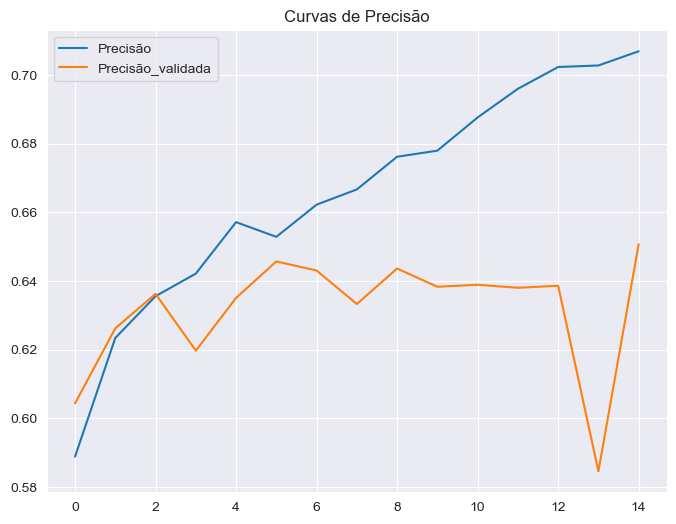

In [19]:
# Analisando agora, a precisão do melhor modelo

plt.figure(figsize=(8,6))
plt.title("Curvas de Precisão")
plt.plot(history.history["accuracy"], label="Precisão")
plt.plot(history.history["val_accuracy"], label="Precisão_validada")
plt.legend()
plt.show()

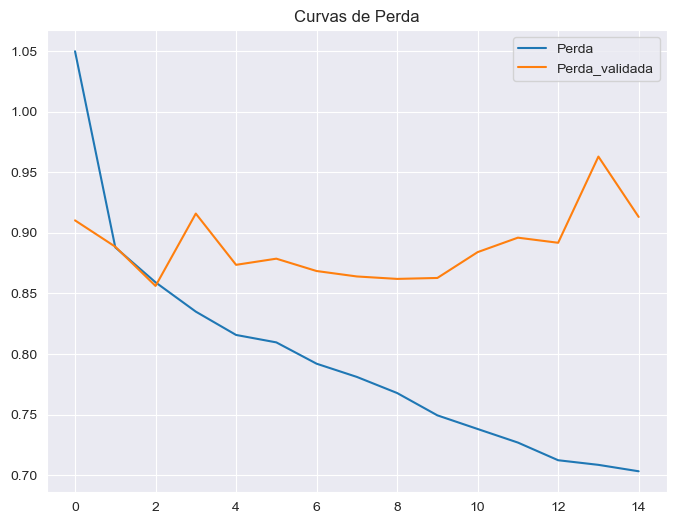

In [20]:
plt.figure(figsize=(8,6))
plt.title("Curvas de Perda")
plt.plot(history.history["loss"], label="Perda")
plt.plot(history.history["val_loss"], label="Perda_validada")
plt.legend()
plt.show()